In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#### Description :
This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data (see details at: http://www.dsi.uminho.pt/~pcortez/forestfires).

| Variable | Description| Units |
| :------- | :------: | :------: |
| X | x-axis spatial coordinate within the Montesinho park map: 1 to 9 | 
| Y | y-axis spatial coordinate within the Montesinho park map: 2 to 9 | 
| month | month of the year: 'jan' to 'dec' |
| day | day of the week: 'mon' to 'sun'|
| FFMC | FFMC index from the FWI system: 18.7 to 96.20 |
| DMC | DMC index from the FWI system: 1.1 to 291.3 |
| DC | DC index from the FWI system: 7.9 to 860.6 |
| ISI | ISI index from the FWI system: 0.0 to 56.10 | Celsius degrees |
| RH | relative humidity: 15.0 to 100 | % |
| wind | wind speed: 0.40 to 9.40 | km/h |
| rain | outside rain: 0.0 to 6.4 | mm/m2 |
| area | the burned area of the forest: 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform). | ha(hectare = 10,000 square meters (m²)) |

#### Target Variable:
Target Variable: area

In [31]:
data = pd.read_csv('Forestfires.csv')
pd.set_option('display.max_columns', None)

In [32]:
data.head()

X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [34]:
pd.isnull(data).sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [35]:
data.shape

(517, 13)

In [36]:
data.describe().T

count        mean         std   min    25%     50%     75%      max
X     517.0    4.669246    2.313778   1.0    3.0    4.00    7.00     9.00
Y     517.0    4.299807    1.229900   2.0    4.0    4.00    5.00     9.00
FFMC  517.0   90.644681    5.520111  18.7   90.2   91.60   92.90    96.20
DMC   517.0  110.872340   64.046482   1.1   68.6  108.30  142.40   291.30
DC    517.0  547.940039  248.066192   7.9  437.7  664.20  713.90   860.60
ISI   517.0    9.021663    4.559477   0.0    6.5    8.40   10.80    56.10
temp  517.0   18.889168    5.806625   2.2   15.5   19.30   22.80    33.30
RH    517.0   44.288201   16.317469  15.0   33.0   42.00   53.00   100.00
wind  517.0    4.017602    1.791653   0.4    2.7    4.00    4.90     9.40
rain  517.0    0.021663    0.295959   0.0    0.0    0.00    0.00     6.40
area  517.0   12.847292   63.655818   0.0    0.0    0.52    6.57  1090.84

In [37]:
numerical_cols = data.select_dtypes(include=[np.number])

In [38]:
numerical_cols.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

In [39]:
categorical_cols = data.select_dtypes(include=['category', object])

In [40]:
categorical_cols.columns

Index(['month', 'day'], dtype='object')

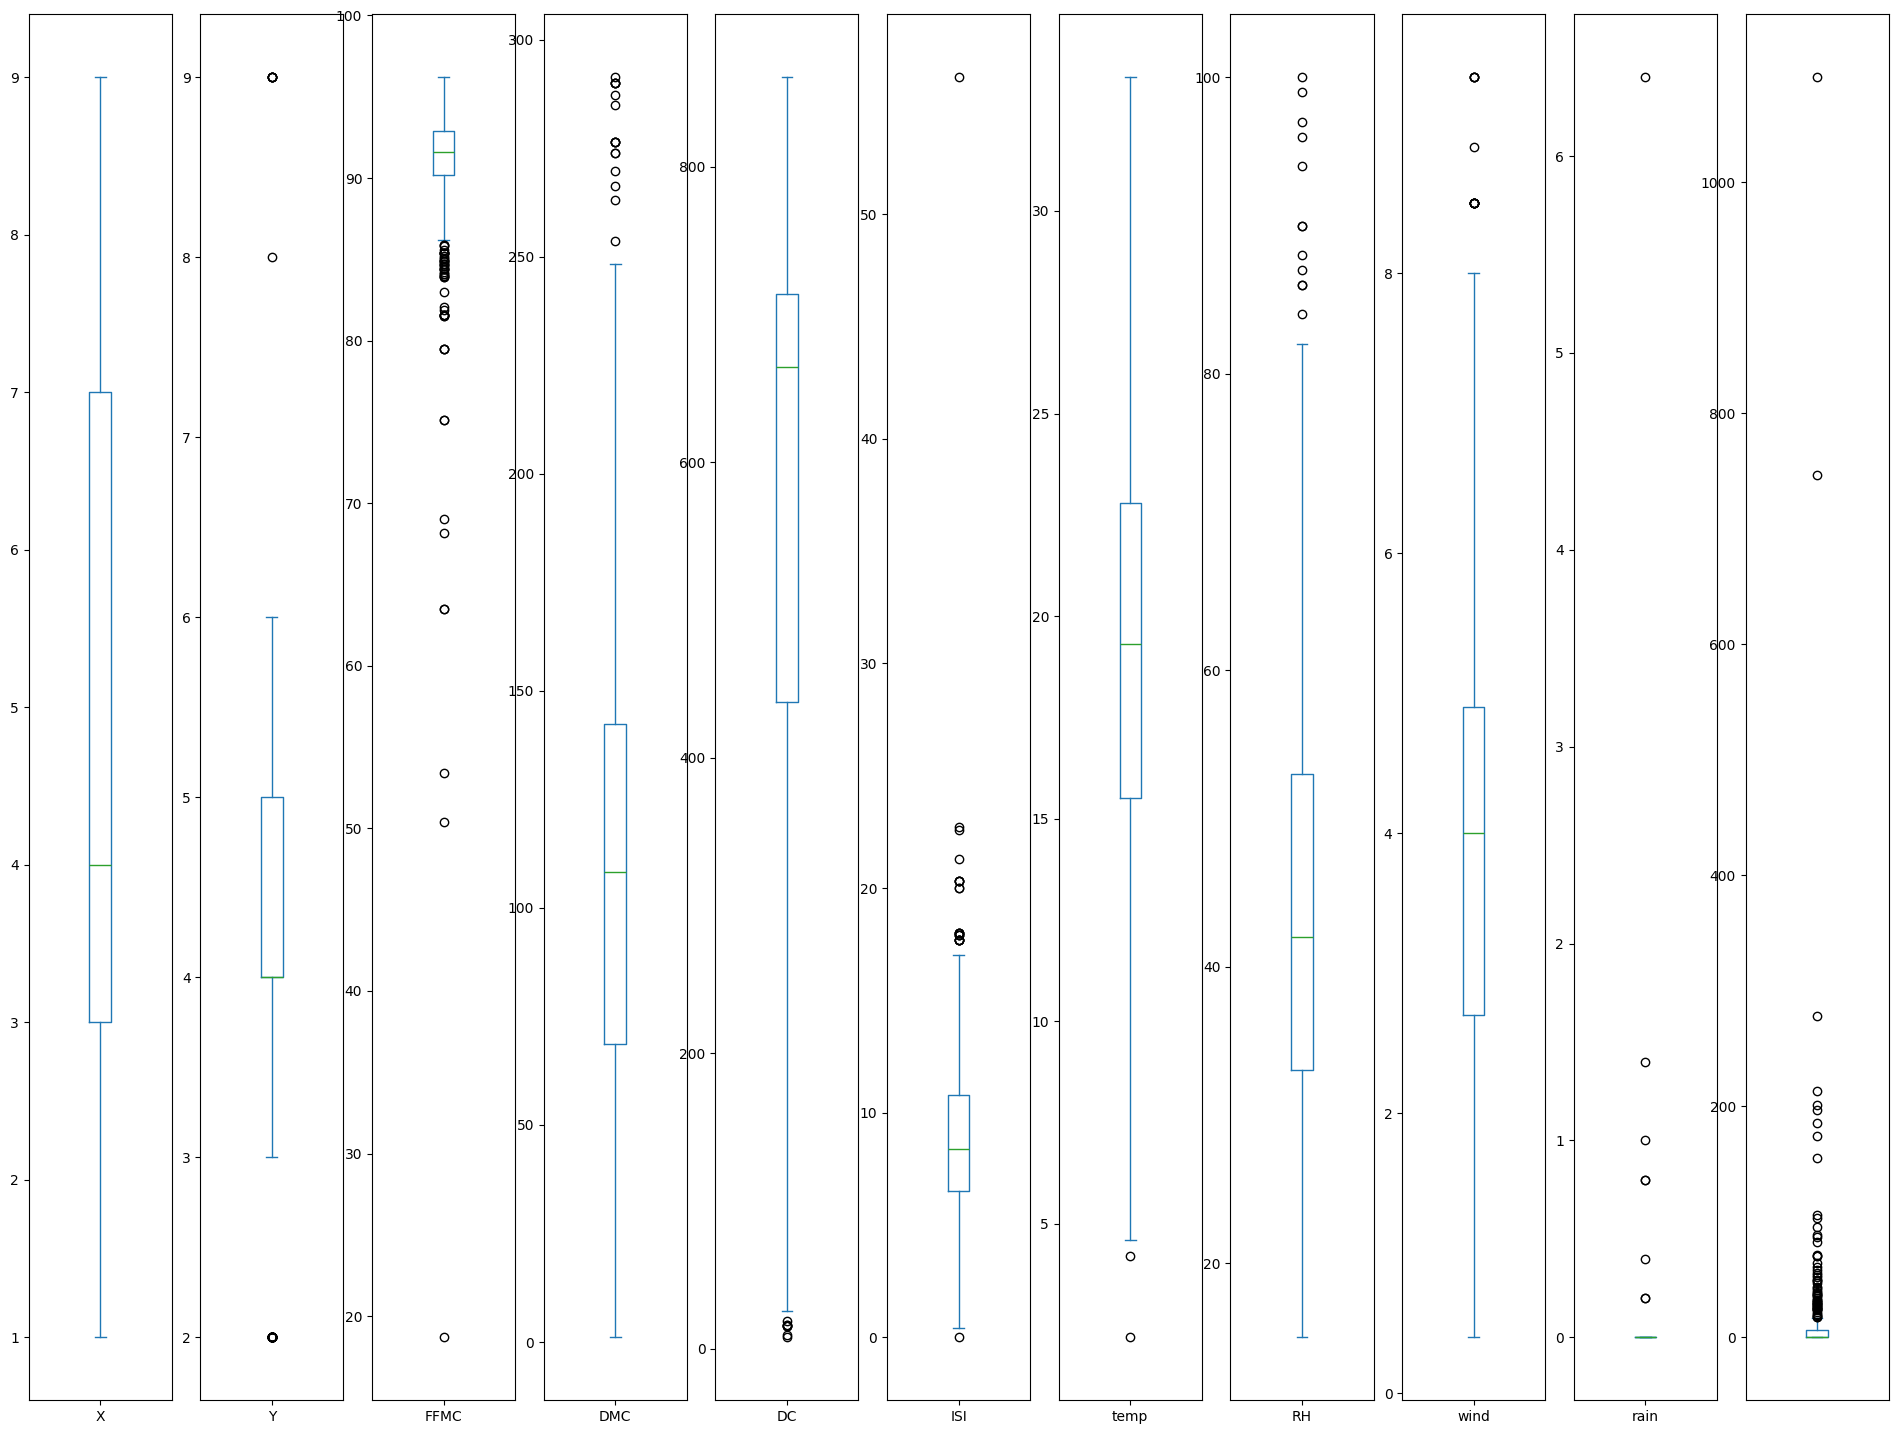

In [41]:
data.plot(kind="box", subplots=True, figsize=(24,18))
plt.xticks([])
plt.show()

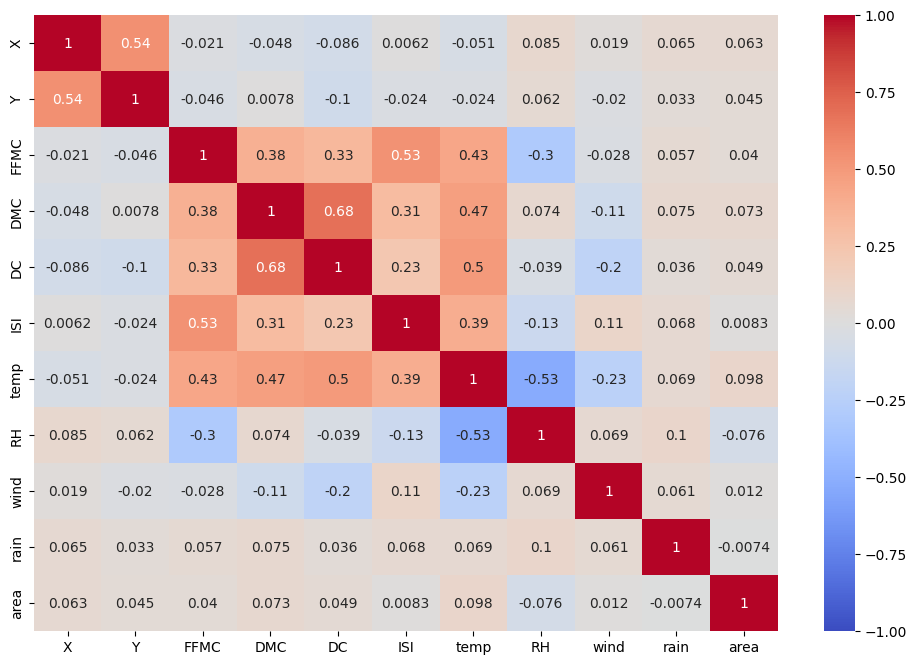

In [42]:
plt.figure(figsize=(12, 8))
numeric_cols = data.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True, vmin=-1, cmap='coolwarm')
plt.show()

In [43]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
# Features and target
X = data.drop(columns=["area"])
y = data["area"]

In [45]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42)

In [46]:
categorical_features=['month', 'day']

In [47]:
# 3. Initialize CatBoost Regressor
cat_model = CatBoostRegressor(
    iterations=1000,        # Number of trees
    learning_rate=0.05,     # Step size
    depth=6,                # Depth of each tree
    loss_function='RMSE',   # Regression loss
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

In [48]:
# 4. Train the model
cat_model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	learn: 48.3300684	test: 89.2693860	best: 89.2693860 (0)	total: 87ms	remaining: 1m 26s
100:	learn: 34.3491254	test: 89.4092789	best: 89.2061838 (17)	total: 5.86s	remaining: 52.2s
200:	learn: 27.1612144	test: 89.0530045	best: 89.0084171 (191)	total: 11.5s	remaining: 45.5s
300:	learn: 21.7803631	test: 89.3850860	best: 89.0084171 (191)	total: 17.1s	remaining: 39.8s
400:	learn: 17.1372505	test: 89.8225667	best: 89.0084171 (191)	total: 23.3s	remaining: 34.8s
500:	learn: 13.8729578	test: 89.9571252	best: 89.0084171 (191)	total: 29s	remaining: 28.9s
600:	learn: 11.6378692	test: 90.0795617	best: 89.0084171 (191)	total: 35.4s	remaining: 23.5s
700:	learn: 9.9720241	test: 90.1475140	best: 89.0084171 (191)	total: 41.1s	remaining: 17.5s
800:	learn: 8.7573597	test: 90.2263899	best: 89.0084171 (191)	total: 47.1s	remaining: 11.7s
900:	learn: 7.7164321	test: 90.1966502	best: 89.0084171 (191)	total: 52.8s	remaining: 5.8s
999:	learn: 6.9168516	test: 90.1533152	best: 89.0084171 (191)	total: 58.3s	remain

In [49]:
# Make predictions
y_pred = cat_model.predict(X_test)

In [50]:
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [51]:
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 89.0084
R2 Score: 0.0045


In [52]:
# Feature importance
importances = cat_model.get_feature_importance(prettified=True)
print(importances)

   Feature Id  Importances
0         DMC    16.403591
1        temp    14.314628
2       month    12.431920
3          RH    12.070097
4           X    11.477499
5         day    10.209174
6        FFMC     7.389223
7           Y     5.952854
8        wind     4.907669
9          DC     3.479024
10        ISI     1.263656
11       rain     0.100664


In [53]:
#SHAP concepts
import shap

In [55]:
explainer = shap.TreeExplainer(cat_model) #This reads:Tree splits, Leaf values, Base value (expected value)

In [57]:
# Get SHAP values for all test samples
shap_values = explainer.shap_values(X_test)

# Pick the first area on fire
area_index = 0
area_shap = shap_values[area_index]
area_features = X_test.iloc[area_index]

In [58]:
# Combine feature names, feature values, and SHAP values
shap_data = pd.DataFrame({
    "Feature": X_test.columns,
    "Value": area_features.values,
    "SHAP_contribution": area_shap
})

# Sort by absolute contribution
shap_data["abs_SHAP"] = shap_data["SHAP_contribution"].abs()
shap_data = shap_data.sort_values(by="abs_SHAP", ascending=False).drop("abs_SHAP", axis=1)

shap_data

Feature  Value  SHAP_contribution
8     temp   11.3          -2.836198
10    wind    4.9           2.375360
9       RH     94          -1.310675
0        X      6          -1.307087
5      DMC   28.0          -0.798573
6       DC  113.8           0.472407
3      day    sat           0.408403
2    month    may           0.310554
4     FFMC   85.1           0.160145
7      ISI    3.5           0.118777
1        Y      5          -0.106092
11    rain    0.0           0.055320

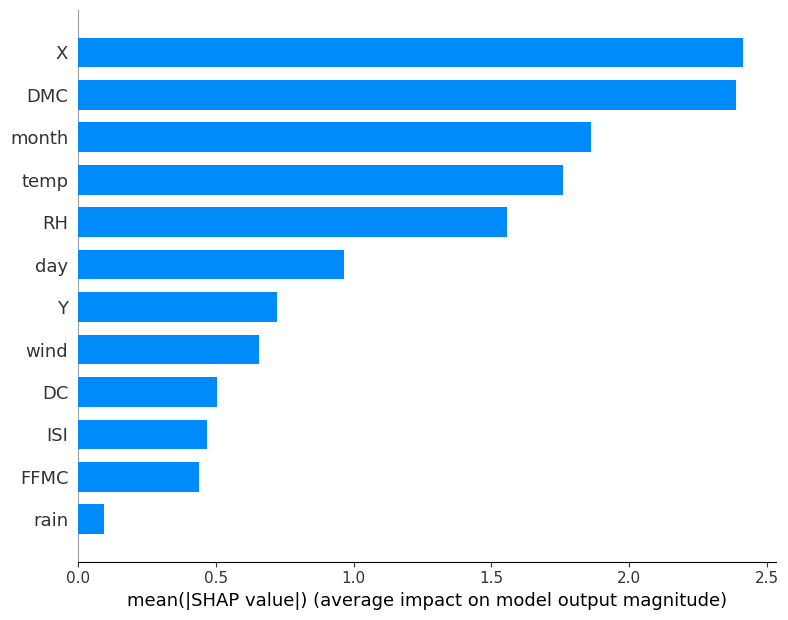

In [59]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [60]:
# Initialize JS visualization
shap.initjs()

# Force plot for the first area on fire
shap.force_plot(
    explainer.expected_value,  # base value (average prediction in log-odds)
    shap_values[0],            # SHAP values for this area
    X_test.iloc[0]             # feature values (labels)
)

In [64]:
# Base value
base_value = explainer.expected_value
print(f"Base Value: {base_value:.2f}")

# Compute final prediction
print(f"SHAP Value for area: {area_shap.sum():.2f}")
prediction = base_value + area_shap.sum()
print(f"Final prediction of area on acres: {prediction:.2f}")

Base Value: 11.64
SHAP Value for area: -2.46
Final prediction of area on acres: 9.18
